In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:23<00:00,  5.43it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [5]:
answers = []
code2answers= defaultdict(list)
for code , convos in code2convos.items():
    gpt_ans = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            gpt_ans.append(conv["text"])
    code2answers[code] = gpt_ans

In [6]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [7]:
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [8]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [10]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [12]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [13]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.489240,0.511177,0.710896,0.572054,0.644308,0.632127,0.432034,0.513471,0.454699
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.527941,0.845154,0.879625,0.910446,0.707233,0.990174,0.902690,0.695725,0.655610
2,041f950b-c013-409a-a642-cffff60b9d4b,0.619105,0.553403,0.820966,0.502106,0.721259,0.638146,0.735648,0.783107,0.557671
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.512092,0.327327,0.439272,0.509525,0.421544,0.460738,0.382360,0.536745,0.648181
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.530178,0.669894,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.534661,0.463338,0.658700,0.463281,0.390146,0.697587,1.000000,0.964054,0.872503
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.485592,0.425532,0.651826,0.960986,0.854723,0.884521,0.657895,0.941956,0.645497
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.591718,0.897085,0.986288,0.951034,0.938313,0.953715,0.903805,0.891365,0.631169
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.524558,0.963624,1.000000,0.825210,0.973199,0.926568,1.000000,1.000000,0.855337


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [14]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["thank", "next", "Entropy", "=", "hyperparameters", ]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [15]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,0.017986,18.850913


In [16]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


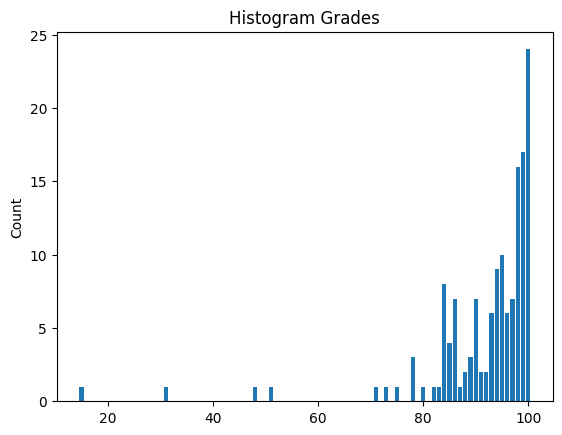

In [17]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [18]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,0.017986,18.850913


In [19]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,2.205748,212.206370,0.489240,0.511177,0.710896,0.572054,0.644308,0.632127,0.432034,0.513471,0.454699
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.304163,113.633582,0.527941,0.845154,0.879625,0.910446,0.707233,0.990174,0.902690,0.695725,0.655610
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,0.262324,17.187601,0.619105,0.553403,0.820966,0.502106,0.721259,0.638146,0.735648,0.783107,0.557671
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,0.123346,107.092566,0.512092,0.327327,0.439272,0.509525,0.421544,0.460738,0.382360,0.536745,0.648181
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,0.017986,18.850913,0.530178,0.669894,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829


In [20]:
df['Average'] = df[['Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8']].mean(axis=1)
df['std'] = df[['Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8']].std(axis=1)

In [21]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,prompt_avg_chars,response_avg_chars,Q_0,...,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Average,std,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,2.205748,212.206370,0.489240,...,0.710896,0.572054,0.644308,0.632127,0.432034,0.513471,0.454699,0.551112,0.094560,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.304163,113.633582,0.527941,...,0.879625,0.910446,0.707233,0.990174,0.902690,0.695725,0.655610,0.790511,0.150342,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,0.262324,17.187601,0.619105,...,0.820966,0.502106,0.721259,0.638146,0.735648,0.783107,0.557671,0.659046,0.111494,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,0.123346,107.092566,0.512092,...,0.439272,0.509525,0.421544,0.460738,0.382360,0.536745,0.648181,0.470865,0.094171,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,0.017986,18.850913,0.530178,...,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829,0.765856,0.136377,100.0


#### Correlation Exploration

<ipython-input-22-1bf414c563f7>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = temp_df.corr()


Correlations with the target variable ('grade'):
grade                 1.000000
#user_prompts         0.190800
Q_7                   0.179200
Q_5                   0.175732
Q_6                   0.161786
Q_3                   0.158116
Q_8                   0.149019
std                   0.146620
#thank                0.137831
Average               0.136090
#entropy              0.133468
#=                    0.119555
#hyperparameters      0.103651
Q_2                   0.098613
#next                 0.077523
Q_1                   0.048737
Q_4                  -0.000114
Q_0                  -0.019103
response_avg_chars   -0.419396
prompt_avg_chars     -0.443420
Name: grade, dtype: float64


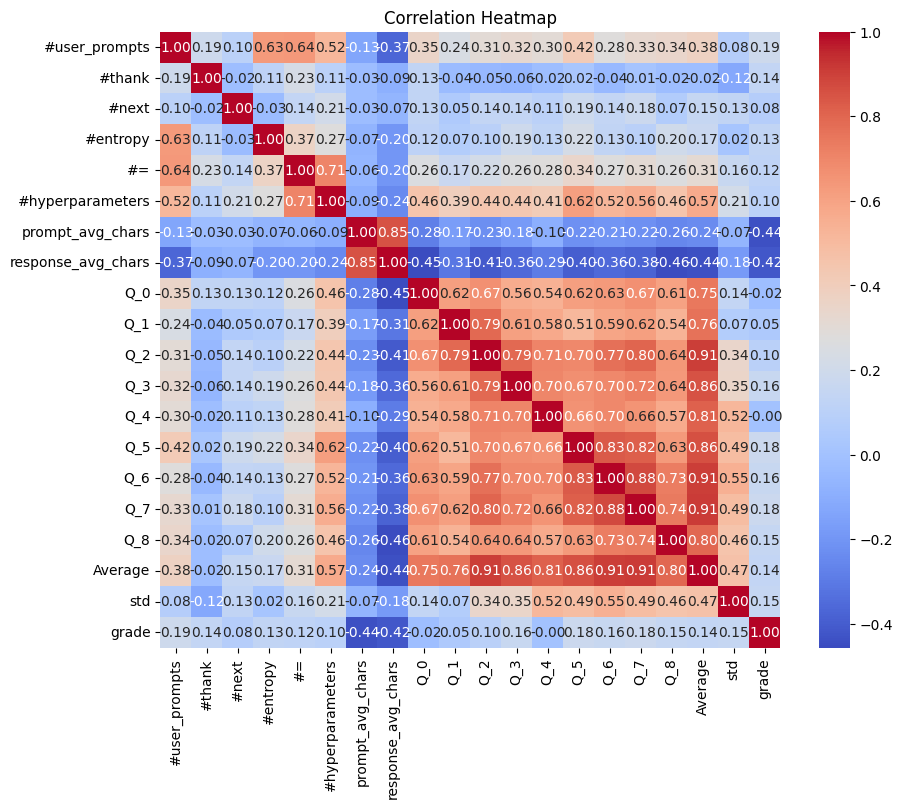


Best 3 features based on absolute values of correlations:
Index(['prompt_avg_chars', 'response_avg_chars', '#user_prompts'], dtype='object')


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations for all features
correlations = temp_df.corr()

# Highlight strong correlations with the target variable ('health_metrics')
target_correlations = correlations['grade'].sort_values(ascending=False)
print("Correlations with the target variable ('grade'):")
print(target_correlations)

# Plot the results in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Select the best 3 features based on absolute values of correlations
best_features = target_correlations.drop('grade').abs().nlargest(3).index

print("\nBest 3 features based on absolute values of correlations:")
print(best_features)

In [27]:
temp_df.head()

,code,#user_prompts,#thank,#next,#entropy,#=,#hyperparameters,prompt_avg_chars,response_avg_chars,Q_0,...,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Average,std,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,0.0,0.0,3.0,2.205748,212.206370,0.489240,...,0.710896,0.572054,0.644308,0.632127,0.432034,0.513471,0.454699,0.551112,0.094560,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,0.0,11.0,0.304163,113.633582,0.527941,...,0.879625,0.910446,0.707233,0.990174,0.902690,0.695725,0.655610,0.790511,0.150342,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,1.0,0.0,3.0,0.0,8.0,0.262324,17.187601,0.619105,...,0.820966,0.502106,0.721259,0.638146,0.735648,0.783107,0.557671,0.659046,0.111494,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,3.0,0.0,0.0,0.123346,107.092566,0.512092,...,0.439272,0.509525,0.421544,0.460738,0.382360,0.536745,0.648181,0.470865,0.094171,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.0,0.0,26.0,29.0,14.0,0.017986,18.850913,0.530178,...,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829,0.765856,0.136377,100.0


In [134]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load your dataset into a pandas DataFrame
# df = pd.read_csv('your_dataset.csv')

# Split your original dataset into two parts: one for training and one for testing
df_train, df_test = train_test_split(temp_df, test_size=0.25, random_state=42)



# A function to compare grades and return the appropriate label
def compare_grades(grade_i, grade_j):
    if grade_i > grade_j:
        return 'higher'
    elif grade_i < grade_j:
        return 'lower'
    else:
        return 'same'

# Function to create a dataset with pairwise comparisons
def create_comparison_dataset(temp_df):
    # Generate all possible unique pairs (i, j) where i != j
    pairs = list(itertools.permutations(temp_df.index, 2))

    # Create an empty DataFrame for the new dataset
    grade_first = pd.DataFrame()
    new_dataset = pd.DataFrame()
    grades = pd.DataFrame()
    for i, j in pairs:
        # Concatenate the features of i and j
        features_i = temp_df.loc[i, temp_df.columns != 'grade']
        features_j = temp_df.loc[j, temp_df.columns != 'grade']
        features_i = features_i.add_suffix('_x')
        features_j = features_j.add_suffix('_y')
        combined_features = pd.concat([features_i, features_j])

        # Compare grades and assign label
        grade_i = temp_df.loc[i, 'grade']
        grade_j = temp_df.loc[j, 'grade']
        grade_i1 = temp_df.loc[i, temp_df.columns =='grade']
        grade_j1 = temp_df.loc[j, temp_df.columns == 'grade']
        grade_i1 = grade_i1.add_suffix('_x')
        grade_j1 = grade_j1.add_suffix('_y')
        label = compare_grades(grade_i, grade_j)

        combined_grades = pd.concat([grade_i1, grade_j1])
        grades = grades.append(combined_grades, ignore_index=True)

        grade_first = grade_first.append([grade_i], ignore_index = True)

        # Append the combined features and label to the new dataset
        combined_features['label'] = label
        new_dataset = new_dataset.append(combined_features, ignore_index=True)
        print(combined_grades)

    return new_dataset, grades, grade_first

# Create the training dataset using pairwise comparisons


In [135]:
training_dataset, training_grades, training_grades_first = create_comparison_dataset(df_train)
test_dataset, test_grades, test_grades_first = create_comparison_dataset(df_test)



Output hidden; open in https://colab.research.google.com to view.

In [136]:
training_dataset.drop(['code_x', 'code_y'], axis = 1, inplace = True)
test_dataset.drop(['code_x', 'code_y'], axis = 1, inplace = True)


In [137]:
test_dataset.head()

,#user_prompts_x,#thank_x,#next_x,#entropy_x,#=_x,#hyperparameters_x,prompt_avg_chars_x,response_avg_chars_x,Q_0_x,Q_1_x,...,Q_2_y,Q_3_y,Q_4_y,Q_5_y,Q_6_y,Q_7_y,Q_8_y,Average_y,std_y,label
0,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.369686,0.190261,0.211830,0.231379,0.289122,0.318874,0.495074,0.302970,0.099930,higher
1,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,1.000000,1.000000,0.973199,0.932674,1.000000,0.695725,0.838158,0.830726,0.203182,lower
2,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.940730,0.787979,0.961364,0.870220,0.747001,0.898952,0.782508,0.794361,0.146963,higher
3,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829,0.765856,0.136377,lower
4,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.879780,0.897223,0.793038,0.900442,0.790695,0.823380,0.657952,0.773591,0.120258,lower


In [142]:

# Extract features and labels for training
X_train = training_dataset.drop('label', axis=1)
y_train = training_dataset['label']

# Extract features and labels for testing
X_test = test_dataset.drop('label', axis=1)
y_test = test_dataset['label']

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state = 42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy}")
print(conf_matrix)


Accuracy on Test Set: 0.5666666666666667
[[266 165   0]
 [170 261   0]
 [ 32  36   0]]


In [143]:
print(training_grades, training_grades_first)

      grade_x  grade_y
0       100.0     94.0
1       100.0     97.0
2       100.0     85.0
3       100.0     98.0
4       100.0     90.0
...       ...      ...
8185     92.0     86.0
8186     92.0     96.0
8187     92.0     99.0
8188     92.0     99.0
8189     92.0     84.0

[8190 rows x 2 columns]           0
0     100.0
1     100.0
2     100.0
3     100.0
4     100.0
...     ...
8185   92.0
8186   92.0
8187   92.0
8188   92.0
8189   92.0

[8190 rows x 1 columns]


In [157]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X_train['label'] = le.fit_transform(y_train)
X_test['label'] = le.fit_transform(y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [158]:
X_train.columns

Index(['#user_prompts_x', '#thank_x', '#next_x', '#entropy_x', '#=_x',
       '#hyperparameters_x', 'prompt_avg_chars_x', 'response_avg_chars_x',
       'Q_0_x', 'Q_1_x', 'Q_2_x', 'Q_3_x', 'Q_4_x', 'Q_5_x', 'Q_6_x', 'Q_7_x',
       'Q_8_x', 'Average_x', 'std_x', '#user_prompts_y', '#thank_y', '#next_y',
       '#entropy_y', '#=_y', '#hyperparameters_y', 'prompt_avg_chars_y',
       'response_avg_chars_y', 'Q_0_y', 'Q_1_y', 'Q_2_y', 'Q_3_y', 'Q_4_y',
       'Q_5_y', 'Q_6_y', 'Q_7_y', 'Q_8_y', 'Average_y', 'std_y', 'label'],
      dtype='object')

In [159]:
X_test.head()

,#user_prompts_x,#thank_x,#next_x,#entropy_x,#=_x,#hyperparameters_x,prompt_avg_chars_x,response_avg_chars_x,Q_0_x,Q_1_x,...,Q_2_y,Q_3_y,Q_4_y,Q_5_y,Q_6_y,Q_7_y,Q_8_y,Average_y,std_y,label
0,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.369686,0.190261,0.211830,0.231379,0.289122,0.318874,0.495074,0.302970,0.099930,0
1,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,1.000000,1.000000,0.973199,0.932674,1.000000,0.695725,0.838158,0.830726,0.203182,0
2,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.940730,0.787979,0.961364,0.870220,0.747001,0.898952,0.782508,0.794361,0.146963,0
3,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.874715,0.720577,0.801324,0.902319,0.770552,0.963318,0.659829,0.765856,0.136377,0
4,21.0,1.0,0.0,3.0,0.0,4.0,0.718688,107.728801,0.583963,1.0,...,0.879780,0.897223,0.793038,0.900442,0.790695,0.823380,0.657952,0.773591,0.120258,0


In [160]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load your dataset into a pandas DataFrame
# df = pd.read_csv('your_dataset.csv')

# Split your original dataset into two parts: one for training and one for testing


# Create the training and test datasets using pairwise comparisons

# Extract features and target for training
X_train = X_train
y_train = training_grades_first

# Extract features and target for testing
X_test = X_test
y_test = test_grades_first

# Initialize the regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Train the regressor
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")


<ipython-input-160-12555635b4ab>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(X_train, y_train)


Mean Squared Error on Test Set: 5280.011427096774


In [161]:
y_train

,0
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
8185,92.0
8186,92.0
8187,92.0
8188,92.0


In [162]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")
r2 = r2_score(y_test, y_pred)
print(r2)

Mean Squared Error on Test Set: 5280.011427096774
-33.963830802899594


In [163]:
training_dataset.columns

Index(['#user_prompts_x', '#thank_x', '#next_x', '#entropy_x', '#=_x',
       '#hyperparameters_x', 'prompt_avg_chars_x', 'response_avg_chars_x',
       'Q_0_x', 'Q_1_x', 'Q_2_x', 'Q_3_x', 'Q_4_x', 'Q_5_x', 'Q_6_x', 'Q_7_x',
       'Q_8_x', 'Average_x', 'std_x', '#user_prompts_y', '#thank_y', '#next_y',
       '#entropy_y', '#=_y', '#hyperparameters_y', 'prompt_avg_chars_y',
       'response_avg_chars_y', 'Q_0_y', 'Q_1_y', 'Q_2_y', 'Q_3_y', 'Q_4_y',
       'Q_5_y', 'Q_6_y', 'Q_7_y', 'Q_8_y', 'Average_y', 'std_y', 'label'],
      dtype='object')

In [164]:
y_train

,0
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
8185,92.0
8186,92.0
8187,92.0
8188,92.0


In [165]:
y_pred, y_test

(array([17.24, 17.24, 17.24, 17.24, 17.24, 18.36, 17.24, 18.36, 17.24,
        18.36, 18.36, 18.36, 17.24, 18.36, 17.24, 17.24, 18.36, 18.36,
        17.24, 18.36, 17.24, 18.36, 18.36, 17.24, 18.36, 17.24, 18.36,
        18.36, 18.36, 17.24, 28.28, 28.28, 28.28, 28.28, 28.28, 28.28,
        28.28, 28.28, 28.28, 28.28, 28.28, 28.28, 28.28, 28.28, 28.28,
        28.28, 28.28, 28.28, 27.16, 28.28, 28.28, 28.28, 28.28, 28.28,
        28.28, 28.28, 28.28, 28.28, 28.28, 28.28, 18.52, 17.4 , 18.52,
        18.52, 18.52, 18.52, 17.4 , 18.52, 18.52, 18.52, 18.52, 18.52,
        18.52, 18.52, 18.52, 18.52, 18.52, 18.52, 17.4 , 18.52, 18.52,
        18.52, 18.52, 18.52, 18.52, 17.4 , 18.52, 18.52, 18.52, 17.4 ,
        17.56, 16.44, 16.44, 16.44, 17.56, 17.56, 16.44, 17.56, 16.44,
        17.56, 17.56, 17.56, 16.44, 17.56, 17.56, 17.56, 17.56, 17.56,
        16.44, 17.56, 16.44, 17.56, 17.56, 16.44, 17.56, 16.44, 17.56,
        17.56, 17.56, 16.44, 17.56, 16.44, 16.44, 17.56, 16.44, 17.56,
      